## Scratch

In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs
import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec


from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetPointClouds/from_manifold_meshes/1024/03001627/'
TRAIN_DIR = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/simple_ae_with_chairs/'

experiment_name = 'enc_filter_1_dec_fc_only'
TRAIN_DIR = osp.join(TRAIN_DIR, experiment_name)
VERBOSE = True

In [9]:
file_names = pio.load_filenames_of_input_data(DATA_PATH, verbose=VERBOSE)

all_pclouds, model_names, class_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=10, verbose=VERBOSE)

train_data_, val_data_, test_data_ = pio.train_validate_test_split(
                                                           [all_pclouds,                                                             
                                                            model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)

trs = set(train_data_[1])
vas = set(val_data_[1])
tes = set(test_data_[1])
assert trs.isdisjoint(vas) and vas.isdisjoint(tes) and tes.isdisjoint(trs)


train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [6]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


conf =     Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 40,
               loss = 'Chamfer',
               train_dir = TRAIN_DIR,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.00002,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0, 'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = enc_dec.decoder_only_with_fc,
               )
reset_graph()
ae = PointNetAutoEncoder(experiment_name, conf)

## Evaluate

In [7]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/10]
stats = eval_model(ae, conf, [train_data, test_data], epochs=epochs, verbose=False)

NameError: name 'train_data' is not defined

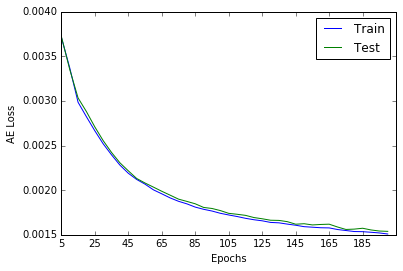

In [16]:
top_save_dir = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/model_evaluation/vanilla_ae', experiment_name)
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [70]:
last_epoch = saved_epochs[-1]
save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)
save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)

In [37]:
# Experimenting with Tensorboard - Visualizations
from tf_lab.fundamentals.inspect import hist_summary_of_trainable
writer = tf.summary.FileWriter('/Users/optas/Desktop/test', ae.graph)
# hist_summary_of_trainable(ae.graph)